In [1]:
from torch import nn, optim
from pathlib import Path
import numpy as np
import jax
import jax.numpy as jnp
import jaxlie
import lietorch
from gecco_torch.utils.isotropic_gaussian import IsotropicGaussianSO3
from gecco_torch.utils.isotropic_plotting import visualize_so3_density, visualize_so3_probabilities
import matplotlib.pyplot as plt
from pathlib import Path
import torch


class SimpleMLP(nn.Module):
    def __init__(self,input_size=10): # input size: 9 von der rotationsmatrix, 1 von variance
        super(SimpleMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
        )
        self.layer_mu = nn.Linear(256, 6)
        self.layer_scale = nn.Linear(6, 1)

    def forward(self, x, s):

        # konvertiere quaternion zu rotation matrix
        rot_mat = lietorch.SO3(x).matrix()[:,:3,:3]
        rot_mat = rot_mat.reshape(-1,9)

        concat = torch.cat([rot_mat, s], dim=-1)
        out = self.mlp(concat)

        mu = self.layer_mu(out)
        R1 = mu[:,0:3] / torch.norm(mu[:,0:3], dim=-1, keepdim=True)
        R3 = torch.cross(R1, mu[:, 3:], dim=-1)
        R3 = R3 / torch.norm(R3, dim=-1, keepdim=True)
        R2 = torch.cross(R3, R1, dim = -1)

        rotation_matrix = torch.stack([R1,R2,R3],dim=-1)

        quat = lietorch.SO3(rotation_matrix,from_rotation_matrix=True)

        scale = self.layer_scale(mu)
        scale = nn.functional.softplus(scale) + 0.0001
        return quat, scale
    


/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/jaxtyping/__init__.py:243: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


In [2]:
@jax.vmap
def sample_dist(seed, size=jnp.pi):
    key1, key2, key3 = jax.random.split(seed, 3)
    x1 = jax.random.uniform(key=key1)*2-1
    x2_ = (jax.random.uniform(key=key2)*2*jnp.pi)-jnp.pi #- jax.random.randint(minval=0, maxval=2,shape=[], key=key3) * 2
    Rs = jaxlie.SO3.from_rpy_radians(pitch=x1, yaw=x2_, roll=0).wxyz
    return Rs

In [3]:
Rs = sample_dist(jax.random.split(jax.random.PRNGKey(0), 4096))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


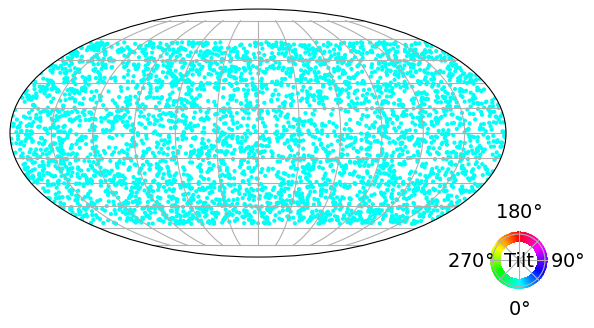

In [25]:
visualize_so3_probabilities(jax.vmap(lambda x: jaxlie.SO3(x).as_matrix())(Rs),
                            0.001)

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


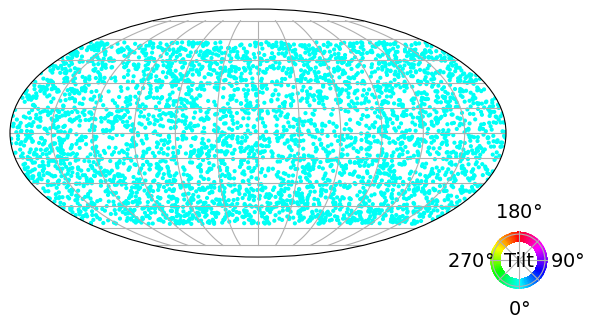

In [29]:
Rs_torch = torch.from_numpy(np.array(Rs))[:,[1,2,3,0]]
l = lietorch.SO3(Rs_torch).matrix()[:,:3,:3]
l_jax = jnp.array(l.cpu().numpy())
visualize_so3_probabilities(l_jax,
                            0.001)
# visualize_so3_probabilities(jax.vmap(lambda x: ),
#                             0.001)

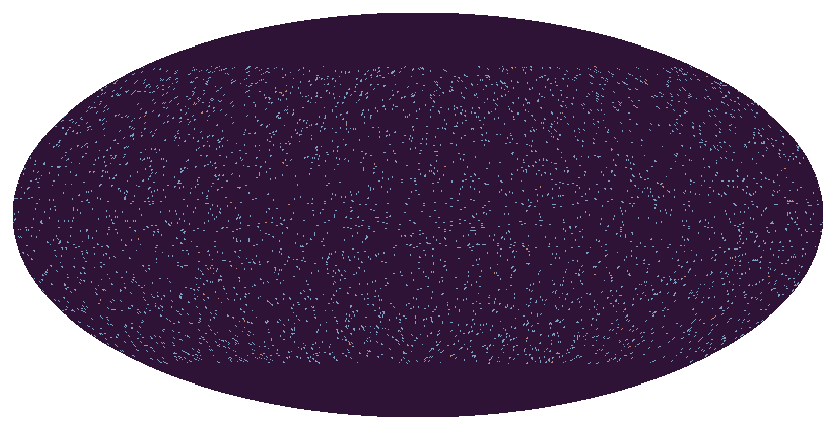

In [5]:
visualize_so3_density(jax.vmap(lambda x: jaxlie.SO3(x).as_matrix())(Rs)
                      ,100)

In [21]:
model = SimpleMLP()

state_dict_path = Path("/home/giese/Documents/gecco/so3models/so3ddpm","checkerboard_2024-05-15_14:53:59.680813","model","checkerboard_vexp_model-210000.pckl")
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


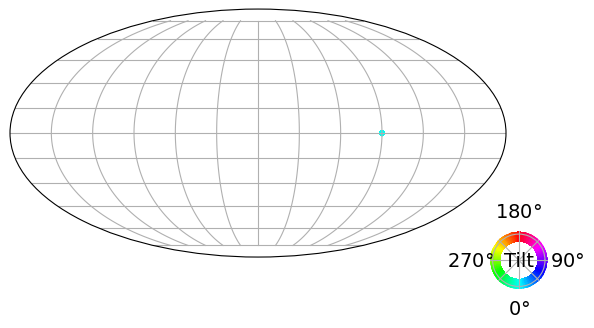

In [22]:
Rs_torch = torch.from_numpy(np.array(Rs))[:,[1,2,3,0]]

s = torch.ones(Rs.shape[0]).reshape([-1,1])

with torch.no_grad():
    mu, scale = model(Rs_torch, s)

visualize_so3_probabilities(jax.vmap(lambda x: jaxlie.SO3(x).as_matrix())(mu.vec()[:,[3,0,1,2]].cpu().numpy()),0.001)

(array([ 14.,  26.,  33., 113., 685., 922., 747., 593., 615., 348.]),
 array([0.13560584, 0.13595793, 0.13631003, 0.13666211, 0.13701421,
        0.13736629, 0.13771838, 0.13807048, 0.13842256, 0.13877466,
        0.13912675]),
 <BarContainer object of 10 artists>)

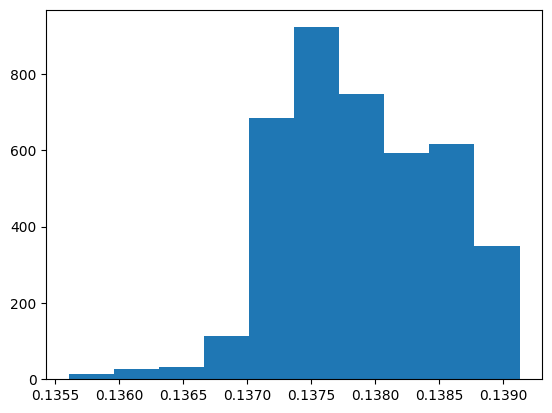

In [23]:
plt.hist(scale.cpu().numpy())

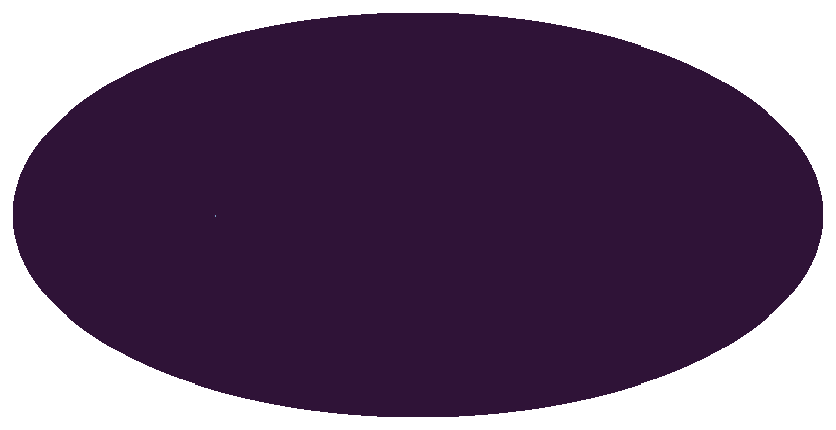

In [24]:
visualize_so3_density(jax.vmap(lambda x: jaxlie.SO3(x).as_matrix())(mu.vec()[:,[3,0,1,2]].cpu().numpy()),100)